<a href="https://colab.research.google.com/github/shlok-kin/MDST-Tutorial/blob/main/Week%206/kaplan_meier_blank_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install lifelines
import pandas as pd
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 5.6 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=07cc40a66df2beb35798d1a8c4533e45d8b11f7712f8044370c3cf583cd77f87
  Stored in directory: /root/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma


# Kaplan-Meier Analysis for COMPAS Recidivism Predictions

Objectives:

1. Compare survival probabilities (recidivism rates) by COMPAS risk score levels (Low, Medium, High).
2. Explore recidivism rates by gender and race.
3. Analyze survival curves to observe disparities between groups over a two-year observation period.

We are using the COMPAS risk scores as a measure to evaluate recidivism predictions. The Kaplan-Meier analysis allows us to estimate the probability of "surviving" (not reoffending) over time and comparing survival rates between different subgroups.

In [2]:
import numpy as np
import seaborn as sns

from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


## Exercise 1: Load in Data

Load in the `cox-parsed.csv` file.

In [41]:
# TODO: Do some EDA on the dataset (explore the columns, shape, etc.)

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/compas-KM-data.csv')

df.head()
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76065 entries, 0 to 76064
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      76065 non-null  int64 
 1   person_id       76065 non-null  int64 
 2   decile_score    76065 non-null  int64 
 3   risk_level      76033 non-null  object
 4   screening_date  76065 non-null  object
 5   sex             76065 non-null  object
 6   race            76065 non-null  object
 7   r_offense_date  40413 non-null  object
 8   in_custody      73773 non-null  object
 9   out_custody     73773 non-null  object
dtypes: int64(3), object(7)
memory usage: 5.8+ MB


,Unnamed: 0,person_id,decile_score
count,76065.00000,76065.000000,76065.000000
mean,38032.00000,5868.643305,4.365727
std,21958.21845,3388.371231,2.857534
min,0.00000,1.000000,-1.000000
25%,19016.00000,2937.000000,2.000000
50%,38032.00000,5850.000000,4.000000
75%,57048.00000,8772.000000,7.000000
max,76064.00000,11757.000000,10.000000


## Exercise 2: Extract Relevant Data for Kaplan-Meier Analysis

In order to successfully extract the necessary data, we need to manipulate our dataframe

*Note*: Create a `two_year_recid` column by checking if `r_offense_date` is within two years (730 days) from screening_date.

*   Set `start` to 0 (representing release date)
*   Set end based on whether recidivism occurred within two years:
    - If `two_year_recid` is 1, set `end` to the days until `r_offense_date`.
    - If `two_year_recid` is 0, set `end` to 730 days.





In [42]:
# TODO: Convert dates to datetime format (['screening_date'], ['r_offense_date'], ['in_custody'], ['out_custody'])
df['screening_date'] = pd.to_datetime(df['screening_date'])
df['r_offense_date'] = pd.to_datetime(df['r_offense_date'])
df['in_custody'] = pd.to_datetime(df['in_custody'])
df['out_custody'] = pd.to_datetime(df['out_custody'])

# TODO: Calculate two_year_recid based on whether recidivism occurred within 2 years
# We'll create a new column 'two_year_recid': 1 for recidivated within 2 years, otherwise 0
# First check if 'r_offense_date' exists for each row of the data set, then check whether the time between
# 'screening_date' and 'r_offense_date' is 730 days or less
df['two_year_recid'] = ((df['r_offense_date'] - df['screening_date']).dt.days <= 730).astype(int)
df.loc[df['r_offense_date'].isna(), 'two_year_recid'] = 0 # If no r_offense_date, then no recidivism

# Set start time to 0 (create a ['start'] column)
df['start'] = 0

# TODO: Define end time based on recidivism status (create an ['end'] column)
df['end'] = df.apply(lambda row: (row['r_offense_date'] - row['screening_date']).days if row['two_year_recid'] == 1 else 730, axis=1)


# TODO: Drop rows with missing data: subset of 'screening_date' and 'end'
df.dropna(subset=['screening_date', 'end'], inplace=True)

# TODO: Display the first few rows of the prepared DataFrame
display(df.head())

,Unnamed: 0,person_id,decile_score,risk_level,screening_date,sex,race,r_offense_date,in_custody,out_custody,two_year_recid,start,end
0,0,1,1,Low,2013-08-14,Male,Other,NaT,2013-08-13 06:03:42,2013-08-14 05:41:20,0,0,730
1,1,1,1,Low,2013-08-14,Male,Other,NaT,2014-07-07 09:26:12,2014-07-14 08:24:15,0,0,730
2,2,1,1,Low,2013-08-14,Male,Other,NaT,2013-08-13 06:03:42,2013-08-14 05:41:20,0,0,730
3,3,1,1,Low,2013-08-14,Male,Other,NaT,2014-07-07 09:26:12,2014-07-14 08:24:15,0,0,730
4,4,1,1,Low,2013-08-14,Male,Other,NaT,2013-08-13 06:03:42,2013-08-14 05:41:20,0,0,730


## Exercise 3: Kaplan-Meier Analysis for COMPAS Risk Levels

1. Use `lifelines` to fit a Kaplan-Meier model for survival analysis.
2. Plot the survival curves for different risk levels (`Low`, `Medium`, `High`) to observe the recidivism trends over time.

*Note*: Remove rows with missing or "N/A" values in the risk level column.

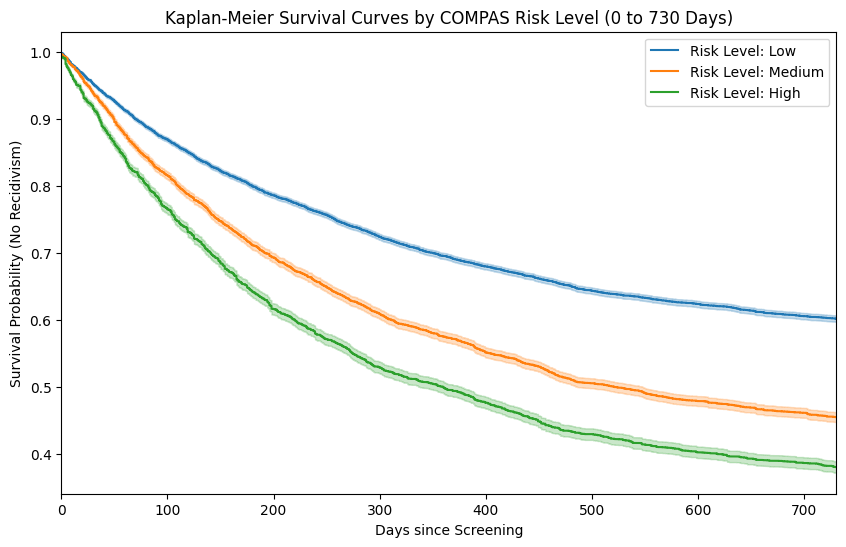

In [44]:
# Initialize Kaplan-Meier fitter
kmf = KaplanMeierFitter()

# Filter out rows with missing or "N/A" risk levels (risk_level) and limit 'end' to be within 0 to 730 days (.notna() might be helpful!)
df_filtered = df[(df['risk_level'].notna()) & (df['risk_level'] != 'N/A') & (df['end'] >= 0) & (df['end'] <= 730)].copy()


# NOTE: for the following plots, we've initialized the structure for you
# TODO: fill in *** placeholders
plt.figure(figsize=(10, 6))

# TODO: Plot Kaplan-Meier curves for each risk level ('risk_level') or if you renamed it to something like 'risk_level'
kmf = KaplanMeierFitter()
for level in df_filtered['risk_level'].unique():
    subset = df_filtered[df_filtered['risk_level'] == level]
    kmf.fit(durations=subset['end'], event_observed=subset['two_year_recid'], label=f'Risk Level: {level}')
    kmf.plot()

# TODO: Customize the plot, labels are up to you!
plt.title("Kaplan-Meier Survival Curves by COMPAS Risk Level (0 to 730 Days)")
plt.xlabel("Days since Screening")
plt.ylabel("Survival Probability (No Recidivism)")
plt.xlim(0, 730)  # Set x-axis limit to 0, 730
plt.xticks(range(0, 731, 100))  # Show ticks from 0 to 730 in intervals of 100 days

# Display the plot
plt.show()

## Exercise 4: Kaplan-Meier Analysis by Demographic Groups (Sex)

1. Compare Kaplan-Meier curves across `sex`.
2. Compare recidivism rates for female and male individuals across different COMPAS risk levels (`Low`, `Medium`, `High`). This allows us to see how recidivism probabilities differ by both gender and risk classification.

Helpful Tips:
*   Use two side-by-side subplots to display the curves for the two racial groups separately.
*   Ensure both plots span from 0 to 730 days, with x-axis tick marks every 100 days.
*   Clearly label each plot with the corresponding racial group, and include legends to show the COMPAS risk levels.

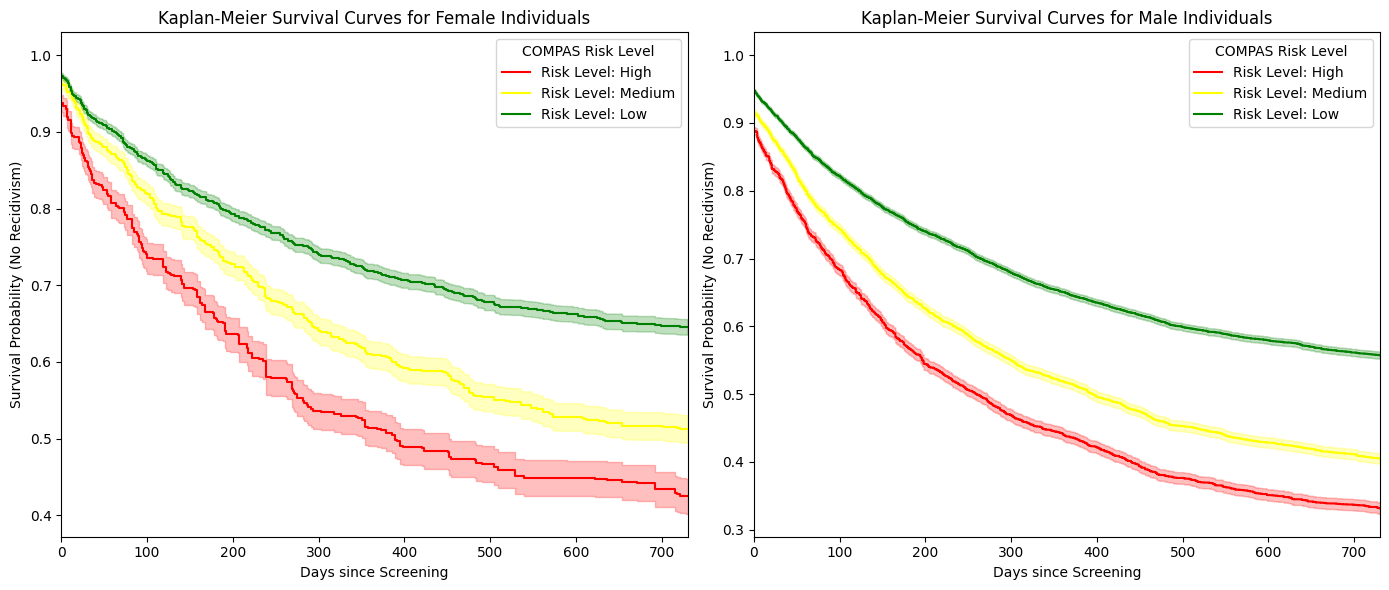

In [48]:
# TODO: Initialize Kaplan-Meier fitter
kmf = KaplanMeierFitter()

# Initialize subplots for side-by-side display
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# TODO: Define COMPAS risk levels to iterate over
# TODO: Fill in the *** placeholders
risk_levels = ['High', 'Medium', 'Low']
colors = ['Red', 'Yellow', 'Green']  # Colors for each risk level, blue, green, etc.

# Plot for Female
female_subset = df[df['sex'] == 'Female']
for risk, color in zip(risk_levels, colors):
    subset = female_subset[female_subset['risk_level'] == risk] # risk_level
    kmf.fit(durations=subset['end'], event_observed=subset['two_year_recid'], label=f'Risk Level: {risk}')
    kmf.plot(ax=axes[0], color=color)

# TODO: Customize the plot, labels are up to you!
axes[0].set_title("Kaplan-Meier Survival Curves for Female Individuals")
axes[0].set_xlabel("Days since Screening")
axes[0].set_ylabel("Survival Probability (No Recidivism)")
axes[0].set_xlim(0, 730)  # Set x-axis limit to 0-730
axes[0].set_xticks(range(0, 731, 100))  # Show ticks from 0 to 730 in intervals of 100 days

# Plot for Male
male_subset = df[df['sex'] == 'Male']
for risk, color in zip(risk_levels, colors):
    subset = male_subset[male_subset['risk_level'] == risk] # risk_level
    kmf.fit(durations=subset['end'], event_observed=subset['two_year_recid'], label=f'Risk Level: {risk}')
    kmf.plot(ax=axes[1], color=color)

# TODO: Customize the plot, labels are up to you!
axes[1].set_title("Kaplan-Meier Survival Curves for Male Individuals")
axes[1].set_xlabel("Days since Screening")
axes[1].set_ylabel("Survival Probability (No Recidivism)")
axes[1].set_xlim(0, 730)  # Set x-axis limit to 0-730
axes[1].set_xticks(range(0, 731, 100))  # Show ticks from 0 to 730 in intervals of 100 days

# Adjust layout and add a legend
axes[0].legend(title="COMPAS Risk Level")
axes[1].legend(title="COMPAS Risk Level")
plt.tight_layout()

# Display the plots
plt.show()

## Exercise 5: Kaplan-Meier Analysis by Demographic Groups (Race)

1. Compare Kaplan-Meier curves across race.
2. Compare recidivism rates for two different racial groups, each broken down by COMPAS risk levels (Low, Medium, High). This will help us examine how survival probabilities differ by both race and risk classification.

Helpful Tips:
*   Use two side-by-side subplots to display the curves for the two racial groups separately.
*   Ensure both plots span from 0 to 730 days, with x-axis tick marks every 100 days.
*   Clearly label each plot with the corresponding racial group, and include legends to show the COMPAS risk levels.

*Note*: Select any two races from the dataset (e.g., Caucasian, African-American, Hispanic, Asian, Other); race strings are case-sensitive. Feel free to try different combinations and observe any trends.

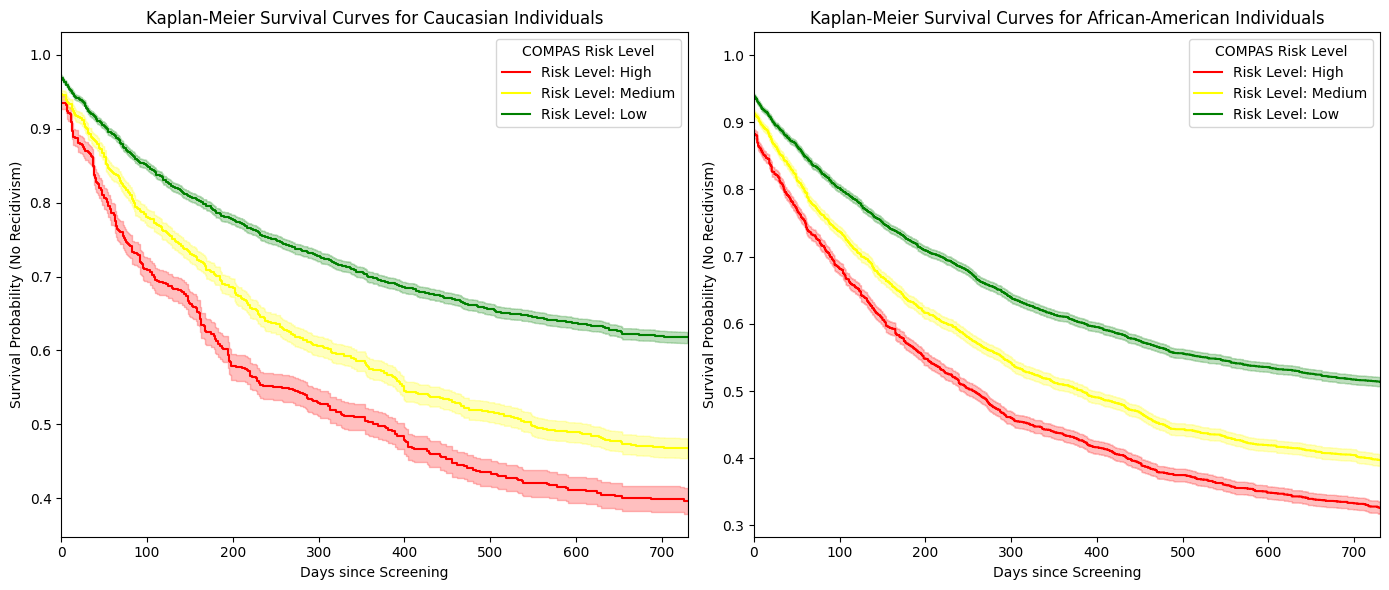

In [49]:
# Initialize Kaplan-Meier fitter

kmf = KaplanMeierFitter()
# Initialize subplots for side-by-side display
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Define the two racial groups you want to compare (feel free to change these; CASE-SENSITIVE)
race1 = 'Caucasian'
race2 = 'African-American'

# Define COMPAS risk levels to iterate over
risk_levels = ['High', 'Medium', 'Low']
colors = ['Red', 'Yellow', 'Green']  # Colors for each risk level

# Plot for the first racial group
race1_subset = df[df['race'] == race1]
for risk, color in zip(risk_levels, colors):
    level_data = race1_subset[race1_subset['risk_level'] == risk] # risk_level
    kmf.fit(durations=level_data['end'], event_observed=level_data['two_year_recid'], label=f'Risk Level: {risk}')
    kmf.plot(ax=axes[0], color=color)

# TODO: Customize the plot, labels are up to you!
axes[0].set_title(f"Kaplan-Meier Survival Curves for {race1} Individuals")
axes[0].set_xlabel("Days since Screening")
axes[0].set_ylabel("Survival Probability (No Recidivism)")
axes[0].set_xlim(0, 730)  # Set x-axis limit to 0-730
axes[0].set_xticks(range(0, 731, 100))  # Show ticks from 0 to 730 in intervals of 100 days

# Plot for the second racial group
race2_subset = df[df['race'] == race2]
for risk, color in zip(risk_levels, colors):
    level_data = race2_subset[race2_subset['risk_level'] == risk] # risk_level
    kmf.fit(durations=level_data['end'], event_observed=level_data['two_year_recid'], label=f'Risk Level: {risk}')
    kmf.plot(ax=axes[1], color=color)

# TODO: Customize the plot, labels are up to you!
axes[1].set_title(f"Kaplan-Meier Survival Curves for {race2} Individuals")
axes[1].set_xlabel("Days since Screening")
axes[1].set_ylabel("Survival Probability (No Recidivism)")
axes[1].set_xlim(0, 730)  # Set x-axis limit to 0-730
axes[1].set_xticks(range(0, 731, 100))  # Show ticks from 0 to 730 in intervals of 100 days

# Adjust layout and add a legend
axes[0].legend(title="COMPAS Risk Level")
axes[1].legend(title="COMPAS Risk Level")
plt.tight_layout()

# Display the plots
plt.show()


## Exercise 6: Calculate Median Survival Times

**Objective**: Calculate the median survival time, which indicates the time at which 50% of the population has recidivated.

1. First, calculate the median survival time for the entire dataset. This gives a general benchmark of when half of the population has recidivated.
2. Then, calculate the median survival time for each COMPAS risk level (e.g., Low, Medium, High). This allows us to see if there are significant differences in the timing or recidivism between risk groups.

*Note*: Filter out entries with 'N/A' in the `score_text` column if needed.

*Note*: If you get infinity for an answer you did not do anything wrong! Think about what this means in the context of the objective above.

In [50]:
# TODO: Fill in the *** placeholders

# TODO: Filter out entries with 'N/A' in the 'risk_level' column, or 'risk_level' if you renamed it
df_filtered = df[df['risk_level'].notna() & (df['risk_level'] != 'N/A')].copy()


# TODO: Initialize the Kaplan-Meier fitter
kmf = KaplanMeierFitter()

# TODO: Calculate median survival time for the entire dataset
kmf.fit(durations=df_filtered['end'], event_observed=df_filtered['two_year_recid'])
median_survival_all = kmf.median_survival_time_

# TODO: Print out the median survival times
# Note: 'inf' as a median survival time means that less than 50% of the population experienced the event within the observed time period.
print(f"Median survival time for the entire dataset: {median_survival_all} days")

# Median survival times by risk level
print("\nMedian survival times by COMPAS Risk Level:")
for level in df_filtered['risk_level'].unique():  # Adjust if 'risk_level' is the correct column for risk level
    subset = df_filtered[df_filtered['risk_level'] == level]
    kmf.fit(durations=subset['end'], event_observed=subset['two_year_recid'])
    median_survival = kmf.median_survival_time_

    # Print these out to visualize the differences (use fstrings!)
    # Note: 'inf' as a median survival time means that less than 50% of the population experienced the event within the observed time period.
    print(f"  {level} Risk Level: {median_survival} days")

Median survival time for the entire dataset: 683.0 days

Median survival times by COMPAS Risk Level:
  Low Risk Level: inf days
  Medium Risk Level: 431.0 days
  High Risk Level: 272.0 days


## Exercise 7: Interpret the Results

**Objective**: Reflect on and interpret the Kaplan-Meier analysis results:
1. How does the recidivism rate change across different COMPAS risk levels?
    - Observe the median survival times for each risk level. Does the median survival time decrease as the risk level increases (i.e., High risk has a shorter median survival time than Low risk)?

2. Are there any noticeable differences in recidivism rates among gender or racial groups?
    - Compare the Kaplan-Meier curves and survival probabilities for different genders and racial groups from earlier exercises. Do certain groups recidivate faster than others?


`Write responses here!` (double click)

*   Or check below this cool plot for our interpretations :D

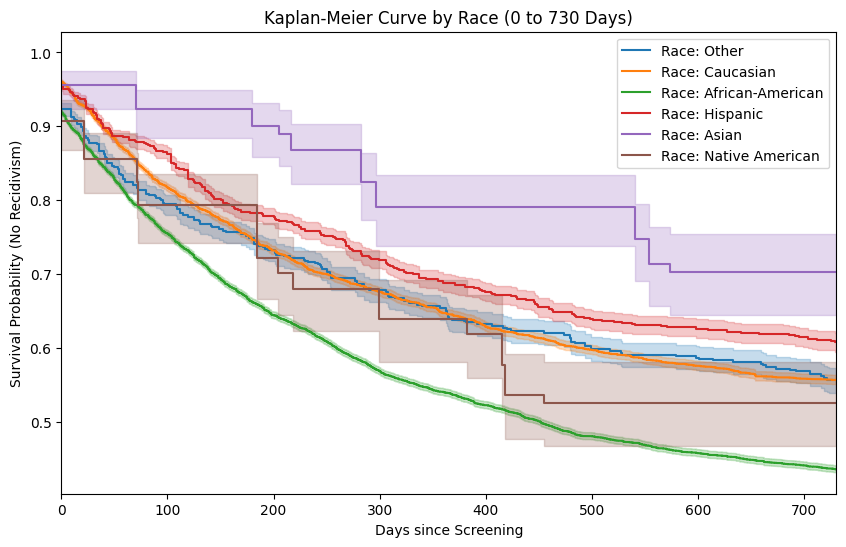

In [51]:
# Cool plot that displays every race in this dataset
# Initialize the plot
plt.figure(figsize=(10, 6))

# Plot Kaplan-Meier curves for each race
for race in df['race'].unique():
    subset = df[df['race'] == race]
    kmf.fit(durations=subset['end'], event_observed=subset['two_year_recid'], label=f'Race: {race}')
    kmf.plot()

# Customize the plot
plt.title("Kaplan-Meier Curve by Race (0 to 730 Days)")
plt.xlabel("Days since Screening")
plt.ylabel("Survival Probability (No Recidivism)")
plt.xlim(0, 730)  # Set x-axis limit to 0-730
plt.xticks(range(0, 731, 100))  # Show ticks from 0 to 730 in intervals of 100 days

# Display the plot
plt.show()


1. *a.* **High-Risk Group:** Median survival time is 272 days, which indicates that half of the individuals in this group reoffend within about 9 months after release. This suggests a high recidivism rate among high-risk individuals.

   *b.* **Medium-Risk Group:** Median survival time is 431 days, meaning this group takes longer to reach the 50% recidivism mark compared to the high-risk group, which is expected.

   *c.* **Low-Risk Group:** Median survival time is "infinity," implying that fewer than 50% of low-risk individuals reoffend within the two-year observation period. This is consistent with their lower risk classification.

2. **Gender:** The survival probabilities likely reveal that men recidivate at a higher rate and earlier time points compared to women. Men in the high-risk group may show a faster decline in survival probability, suggesting they are more prone to reoffend. For women, even in the high-risk group, the survival probability may decrease at a slower rate than men.

3. **Race:** If we compare different racial groups (e.g., Caucasian and African-American), the curves may indicate disparities. For instance, African-American individuals may exhibit a higher rate of recidivism in similar risk categories compared to Caucasian individuals, potentially highlighting racial disparities. This could be due to a range of socio-economic factors and historical biases that may influence both the likelihood of reoffending and the assessment itself.